# Value at Risk

## Contents


1.   Value at Risk (VaR)
2.   Marginal VaR (MVaR)
3.   Component VaR (CVaR)



## Notes

- Value at Risk: **Value at Risk (VaR) is a statistical measure used to estimate the potential loss in value of a portfolio over a defined period for a given confidence interval**. It answers the question: _"What is the worst-case loss we can expect over a certain time horizon, under normal market conditions, with a certain level of confidence?"_

- Three key components of VaR: <u>time horizon, confidence level, and loss amount</u>.

- _"1-day 95% VaR of \$1 million"_: there is a 5% chance (1 - 95%) that the portfolio will loss more than $1 million over a 1-day period under normal market condition.

- Three methods to compute VaR:
  - Parametric  (Variance-Covariance/delta-normal) Method: assumes returns are normally distributed.
    - Pros: simple, fast
    - Cons: assumes normal distribution (underestimate tail risk)
  - Historical Simulation Method: uses past returns to estimate future risk.
    - Pros: no distribution assumption
    - Cons: depends on historical data (may not predict extreme events).
  - Monte Carlo Simulation: simulates thousands of possible future scenarios using random sampling.
    - Pros: flexible, can model complex dependencies
    - Cons: computationally intensive, depends on model assumptions.


#### Reference:

https://letianzj.github.io/value-at-risk-one.html

### Value at Risk (VaR)

Consider a portfolio of $n$ assets with corresponding weights $w$ and covariance matrix $\Sigma$, then the value of this portfolio $V$, the return and risk are:

$V=\Sigma_{i=1}^n V_i$

$r_p = w^T r$

$\sigma_p^2 = w^T \Sigma w$

Assume return normality, the value at risk of the portfolio in dollar amount is

$VaR=(\mu-z\sigma_p)V$,
where $z$ is the critical value (z-score) for the chosen confidence interval (e.g., 1.96 for 95% confidence interval, 1.645 for 90% confidence interval).

For small $\mu$ or short horizons, $\mu\approx0$, simplifying to $z \cdot \sigma \cdot V$.

Due to portfolo diversification, the portfolio VaR is smaller than the sum of each individual VaR.

$VaR_i=z\sigma_i V_i$

$VaR_p<\Sigma_{i=1}^n VaR_i$


### Marginal VaR (MVaR)

It helps in risk budgeting and hedging decisions.

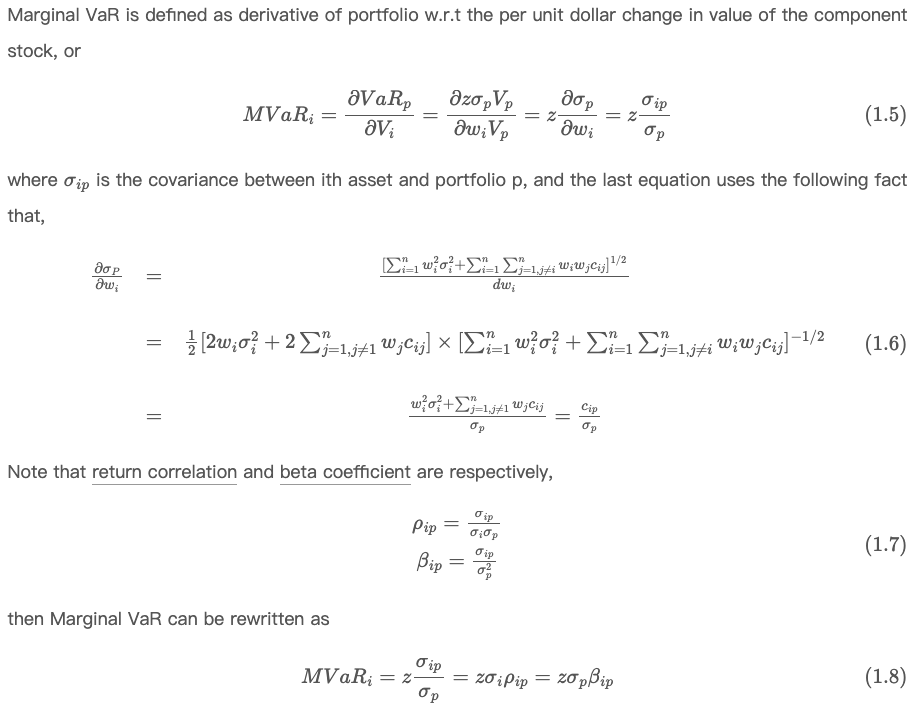

### Component VaR (CVaR)

Helps identify which assets contribute most to risk.

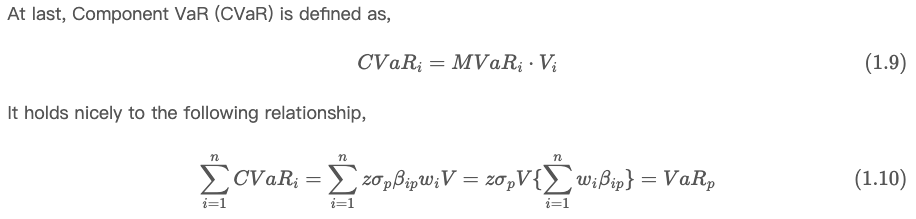

In [26]:
import numpy as np
import pandas as pd
from scipy.stats import norm

In [11]:
# Load data
assets = [
    'AAPL',  # Apple
    'KO',    # Coca-Cola
    'DIS',   # Disney
    'XOM',   # Exxon Mobil
    'JPM',   # JPMorgan Chase
    'MCD',   # McDonald's
    'WMT',   # Walmart
]

holdings = [100, 200, 300, 400, 500, 600, 700] # number of shares in each assets

hist_data = pd.DataFrame()
start_data = '2015-01-01'
end_data = '2017-12-31'
for i in range(len(assets)):
  asset = assets[i]
  data = pd.read_csv("data/" + asset + ".csv")
  mask1 = data['Date'] >= start_data
  mask2 = data['Date'] <= end_data
  data = data[mask1 & mask2]
  if i == 0:
    hist_data['Date'] = data['Date']
    hist_data[asset] = data['Adj Close']
  else:
    hist_data = pd.merge(hist_data, data[['Date', 'Adj Close']], on='Date', how='left')
    hist_data.rename(columns={'Adj Close': asset}, inplace=True)

# Check nan
assert hist_data.isna().sum().sum() == 0

hist_data.shape

(755, 8)

In [12]:
hist_data.head()

,Date,AAPL,KO,DIS,XOM,JPM,MCD,WMT
0,2015-01-02,100.216454,35.491245,87.376266,75.439079,54.462791,80.689468,75.466400
1,2015-01-05,97.393181,35.491245,86.099403,73.374931,52.771992,79.798302,75.246773
2,2015-01-06,97.402374,35.760750,85.642708,72.984848,51.403664,79.945404,75.826607
3,2015-01-07,98.768150,36.207142,86.518814,73.724373,51.482113,81.338379,77.838448
4,2015-01-08,102.563072,36.645096,87.413536,74.951500,52.632545,81.641197,79.481316


In [58]:
# Calculate historical log returns
hist_return = np.log(hist_data.iloc[:, 1:] / hist_data.iloc[:, 1:].shift(1))
hist_return = hist_return.dropna()

port_cov = hist_return.cov() # portfolio covariance matrix
port_corr = hist_return.corr() # portfolio correlation matrix

V_i = hist_data.iloc[-1, 1:] * holdings # dollar value as of end date
V_i = V_i.values
V_p = V_i.sum().item() # dollar value of the portfolio as of end date

z = norm.ppf(0.95, 0, 1).item() # z value
sigma_p = np.sqrt(np.dot(V_i.T, np.dot(port_cov, V_i))).item() # variance in dollar amount
VaR_p = z * sigma_p # portfolio VaR

sigma_i = np.sqrt(np.diag(port_cov)) # individual asset
VaR_i = z * sigma_i * V_i

cov_ip = np.dot(port_cov, V_i) / V_p # covariance
beta_i = cov_ip / (sigma_p*sigma_p/V_p/V_p) # beta
MVar_i = VaR_p/V_p*beta_i # marginal VaR

CVaR_i = MVar_i * V_i # component VaR

CVaR_i_df = pd.DataFrame(data=np.column_stack((V_i, V_i/V_p, CVaR_i, CVaR_i/VaR_p, beta_i)))
CVaR_i_df.index = assets
CVaR_i_df.columns = ['Position ($)', 'Position (%)', 'CVaR ($)', 'CVaR (%)', 'Beta']
CVaR_i_df

,Position ($),Position (%),CVaR ($),CVaR (%),Beta
AAPL,16386.999512,0.054534,204.200329,0.053473,0.98054
KO,8522.102356,0.028361,60.375589,0.01581,0.557472
DIS,31366.202545,0.104383,349.032307,0.091399,0.875612
XOM,30222.509766,0.100577,342.632956,0.089723,0.892086
JPM,50366.443634,0.167614,812.281945,0.212708,1.269035
MCD,97736.068726,0.325255,1226.759469,0.321245,0.987672
WMT,65890.442657,0.219276,823.482502,0.215641,0.983423


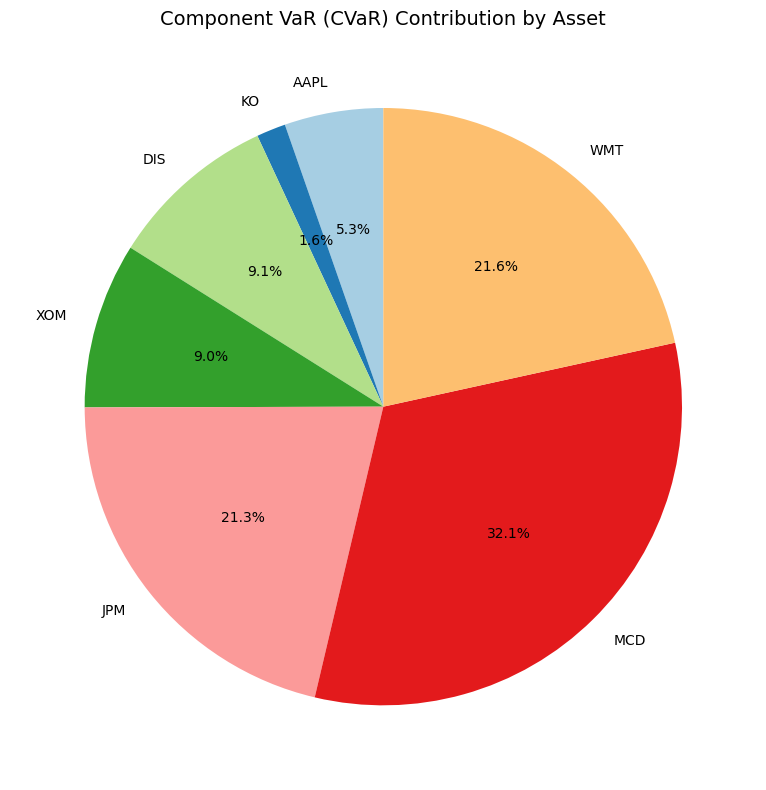

In [59]:
import matplotlib.pyplot as plt

# Create the pie plot
plt.figure(figsize=(8, 8))
plt.pie(CVaR_i_df['CVaR (%)'],
        labels=CVaR_i_df.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Paired.colors)

plt.title('Component VaR (CVaR) Contribution by Asset', fontsize=14)
plt.tight_layout()
plt.show()

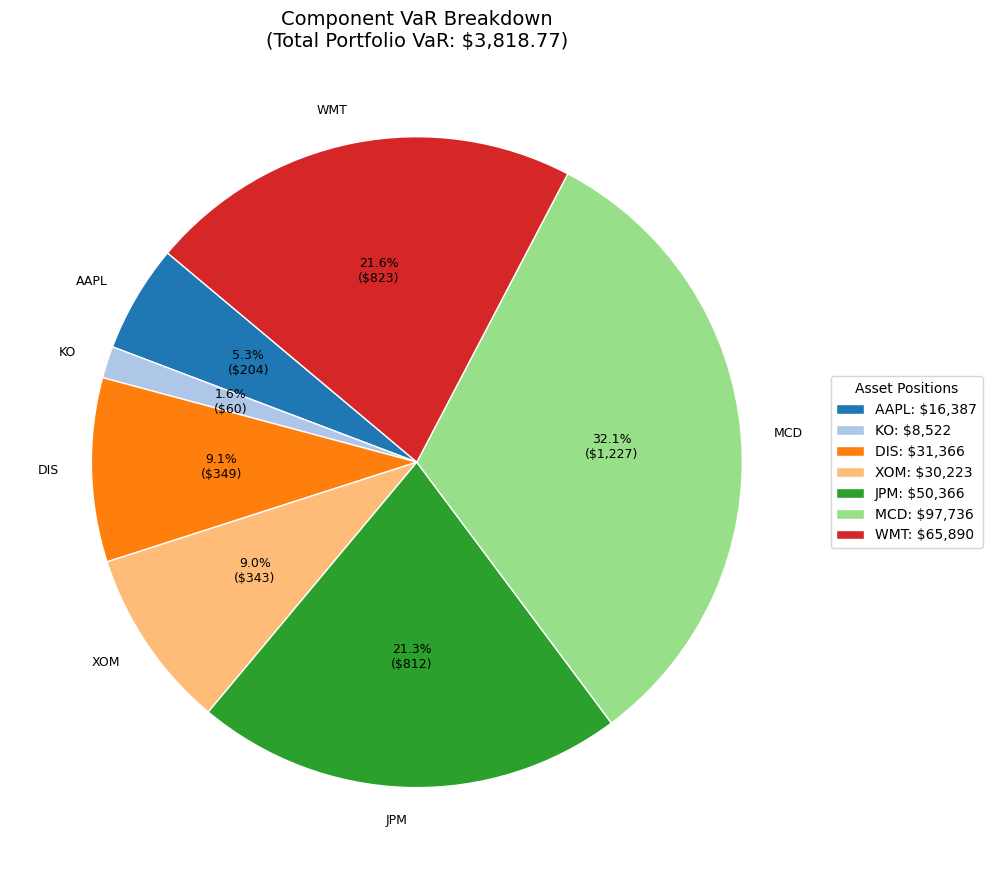

In [60]:
# Create a more detailed pie plot
plt.figure(figsize=(10, 10))
wedges, texts, autotexts = plt.pie(
    CVaR_i_df['CVaR (%)'],
    labels=CVaR_i_df.index,
    autopct=lambda p: f'{p:.1f}%\n(${p/100*VaR_p:,.0f})',
    startangle=140,
    colors=plt.cm.tab20.colors,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    textprops={'fontsize': 9}
)

# Add legend with position values
plt.legend(
    wedges,
    [f'{asset}: ${val:,.0f}' for asset, val in zip(CVaR_i_df.index, CVaR_i_df['Position ($)'])],
    title="Asset Positions",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title(f'Component VaR Breakdown\n(Total Portfolio VaR: ${VaR_p:,.2f})', fontsize=14)
plt.tight_layout()
plt.show()